In [1]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()


General Functions Enabled Successfully


In [2]:
import SimpleITK as sitk
import numpy as np

import utils.general as gen

import nibabel as nib

from skimage import io

import os

import matplotlib.pyplot as plt

In [3]:
id_patient = "1Gj3yjHC1RtxdqHEKz_K8Egl6ZlCrVm_R"

In [4]:
gen.download_file_from_google_drive(id_patient, "maria.zip", size=7.4e3)



Extracting Zip File...
Deleting File...


In [5]:
data_dir = gen.create_and_verify("data", "Maria Rodriguez", 
                                 "images", list_=True)

In [6]:
adc_dir = data_dir[0]
dwi_dir = data_dir[1]
t2_dir = data_dir[2]

In [7]:
adc_img = nib.load(adc_dir).get_fdata()
dwi_img = nib.load(dwi_dir).get_fdata()
t2_img = nib.load(t2_dir).get_fdata()

In [8]:
img0 = dwi_img[..., 23]
img1 = t2_img[..., 18]

In [10]:
pixelType = sitk.sitkFloat32

fixed = sitk.GetImageFromArray(img0)
moving = sitk.GetImageFromArray(img1)

In [11]:
fixed_array = sitk.GetArrayFromImage(fixed)
moving_array = sitk.GetArrayFromImage(moving)

In [18]:
R = sitk.ImageRegistrationMethod()
initial_transform = sitk.CenteredTransformInitializer(
    fixed, moving, sitk.Similarity2DTransform()
)

R.SetMetricAsMattesMutualInformation()
R.SetInterpolator(sitk.sitkLinear)
R.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=1000,
convergenceMinimumValue=1e-6, convergenceWindowSize=10)

R.SetInitialTransform(initial_transform, inPlace=False)

In [31]:
final_transform = R.Execute(sitk.Cast(fixed, sitk.sitkFloat32),
                            sitk.Cast(moving, sitk.sitkFloat32))

In [14]:
resampler = sitk.ResampleImageFilter()

In [32]:
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(final_transform)

out = resampler.Execute(moving)
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

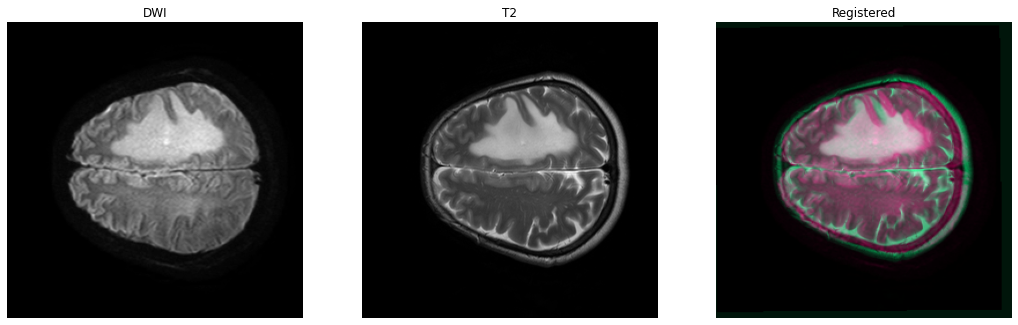

In [33]:
cimg_array = sitk.GetArrayFromImage(cimg)

gen.visualize_subplot([fixed_array, moving_array, cimg_array], ["DWI", "T2", "Registered"],
(1, 3), (18, 6))

# **Método 1**

In [34]:
def command_iteration(method):
    if (method.GetOptimizerIteration() == 0):
        print("Estimated Scales: ", method.GetOptimizerScales())
    print("{0:3} = {1:7.5f} : {2}".format(method.GetOptimizerIteration(),
                                          method.GetMetricValue(),
                                          method.GetOptimizerPosition()))

In [35]:
fixed = sitk.Cast(sitk.GetImageFromArray(img0), pixelType)
moving = sitk.Cast(sitk.GetImageFromArray(img1), pixelType)

In [36]:
R = sitk.ImageRegistrationMethod()

R.SetMetricAsCorrelation()

R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                           minStep=1e-4,
                                           numberOfIterations=500,
                                           gradientMagnitudeTolerance=1e-8)
R.SetOptimizerScalesFromIndexShift()

In [37]:
tx = sitk.CenteredTransformInitializer(fixed, moving,
                                       sitk.Similarity2DTransform())
R.SetInitialTransform(tx)

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

0

In [45]:
outTx = R.Execute(fixed, moving)

Estimated Scales:  (37283.087871081916, 38579.0094442056, 0.999999999998181, 0.999999999998181)
  0 = -0.43119 : (1.0190919183045604, 0.08988841140229462, 178.4770307172348, 106.26308823497925)
  1 = -0.42931 : (1.017365905553071, 0.09027779264324647, 178.8360753977261, 107.19640693010602)
  2 = -0.43069 : (1.015954002621408, 0.09098025099733781, 179.12963784785305, 108.1523455269614)
  3 = -0.43116 : (1.018388965794265, 0.0941052769397555, 178.98354922953854, 107.67417984357732)
  4 = -0.43102 : (1.0178678607042053, 0.09412896019418332, 179.10293875392276, 107.89382926733232)
  5 = -0.43114 : (1.0172757253005695, 0.09420675620671055, 179.23816954088414, 108.10409642497054)
  6 = -0.43119 : (1.016703357188462, 0.09491065815722308, 179.3200124207332, 108.00961933814627)
  7 = -0.43117 : (1.0169068637490233, 0.09498158745405645, 179.28545503360158, 108.06169611366808)
  8 = -0.43119 : (1.0174560633993728, 0.09522689700572261, 179.25383215561212, 108.1156023451319)
  9 = -0.43120 : (1.017

In [46]:
print("-------")
print(outTx)
print("Optimizer stop condition: {0}"
      .format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))

sitk.WriteTransform(outTx, "transform.h5")

-------
itk::simple::Transform
 Similarity2DTransform (0x2840b30)
   RTTI typeinfo:   itk::Similarity2DTransform<double>
   Reference Count: 4
   Modified Time: 18022
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.0126 -0.0969867 
     0.0969867 1.0126 
   Offset: [189.324, 93.0322]
   Center: [139.409, 121.403]
   Translation: [179.306, 108.083]
   Inverse: 
     0.978579 0.0937281 
     -0.0937281 0.978579 
   Singular: 0
   Angle       = 0.0954885
   Scale =1.01723

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Step too small after 27 iterations. Current step (6.10352e-05) is less than minimum step (0.0001).
 Iteration: 28
 Metric value: -0.43118820248458656


In [47]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)

    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

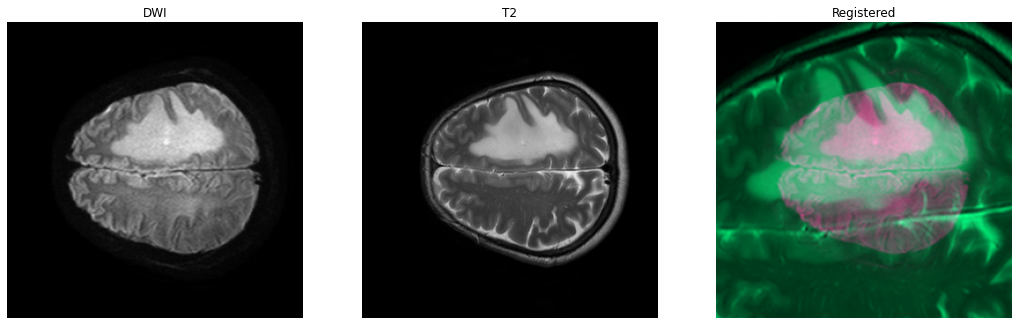

In [48]:
cimg_array = sitk.GetArrayFromImage(cimg)

gen.visualize_subplot([fixed_array, moving_array, cimg_array], ["DWI", "T2", "Registered"],
(1, 3), (18, 6))

# **Método 2**

In [49]:
def command_iteration(method):
    print("{0:3} = {1:7.5f} : {2}".format(method.GetOptimizerIteration(),
                                          method.GetMetricValue(),
                                          method.GetOptimizerPosition()))

In [50]:
fixed = sitk.Cast(sitk.GetImageFromArray(img0), pixelType)
fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.)

In [51]:
moving = sitk.Cast(sitk.GetImageFromArray(img1), pixelType)
moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)

In [52]:
R = sitk.ImageRegistrationMethod()
R.SetMetricAsJointHistogramMutualInformation()
R.SetOptimizerAsGradientDescentLineSearch(learningRate=1.0,
                                          numberOfIterations=200,
                                          convergenceMinimumValue=1e-5,
                                          convergenceWindowSize=5)
R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

0

In [53]:
outTx = R.Execute(fixed, moving)

  0 = -0.46246 : (-0.0017515305477034293, -0.0015460041683384277)
  1 = -0.46253 : (-0.0061867436943423455, -0.005460819017906893)
  2 = -0.46258 : (-0.017418358651964123, -0.01537355619280039)
  3 = -0.46278 : (-0.07316651934424978, -0.0645773642421073)
  4 = -0.46498 : (-0.3386662367708915, -0.2989993529157256)
  5 = -0.47031 : (-1.3978308822638539, -1.2364547570816606)
  6 = -0.48303 : (-6.574688279732018, -5.913159662731379)
  7 = -0.55860 : (-32.62520805375094, -31.236321797103848)
  8 = -1.51138 : (-75.2383476023219, -79.48414802583545)
  9 = -3.35587 : (-130.4021165013404, -161.08293756211668)
 10 = -0.08767 : (-130.4021165013404, -161.08293756211668)


In [54]:
print("-------")
print(outTx)
print("Optimizer stop condition: {0}"
      .format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))

-------
itk::simple::Transform
 TranslationTransform (0x2797740)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 68106
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [-130.402, -161.083]

Optimizer stop condition: GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 11.
 Iteration: 11
 Metric value: -3.3558714696655674


In [55]:
sitk.WriteTransform(outTx, "transform.h5")

In [56]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(1)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)

    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

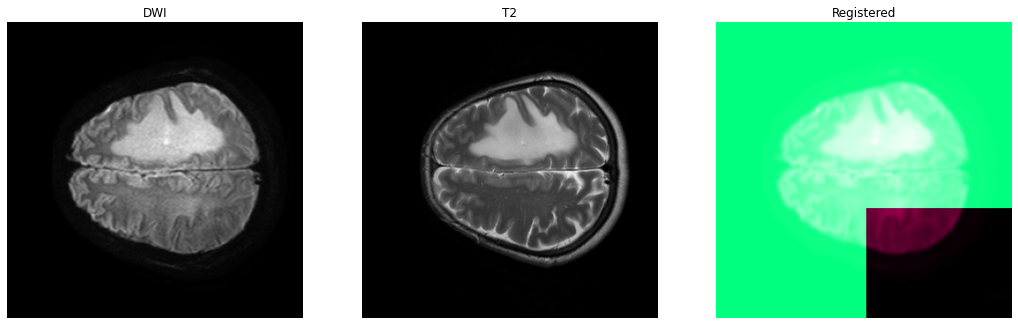

In [57]:
cimg_array = sitk.GetArrayFromImage(cimg)

gen.visualize_subplot([fixed_array, moving_array, cimg_array], ["DWI", "T2", "Registered"],
(1, 3), (18, 6))

# **Método 3**

In [ ]:
fixed = sitk.Cast(sitk.GetImageFromArray(img0), pixelType)
moving = sitk.Cast(sitk.GetImageFromArray(img1), pixelType)

In [ ]:
R = sitk.ImageRegistrationMethod()

In [ ]:
R.SetMetricAsMattesMutualInformation()

In [ ]:
R.SetOptimizerAsRegularStepGradientDescent(4.0, .01, 200)

In [ ]:
transform = sitk.CenteredTransformInitializer(fixed, moving, sitk.Euler2DTransform())

In [ ]:
R.SetInitialTransform(transform)

In [ ]:
R.SetInterpolator(sitk.sitkLinear)

In [ ]:
outTx = R.Execute(fixed, moving)

In [ ]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)
out = resampler.Execute(moving)

In [ ]:
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)

In [ ]:
cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)

In [ ]:
cimg_array = sitk.GetArrayFromImage(cimg)

In [ ]:
gen.visualize_subplot([fixed_array, moving_array, cimg_array], ["DWI", "T2", "Registered"],
(1, 3), (18, 6))

# **Método 4**

In [ ]:
def command_iteration(method):
    print("{0:3} = {1:10.5f} : {2}".format(method.GetOptimizerIteration(),
                                           method.GetMetricValue(),
                                           method.GetOptimizerPosition()))

In [ ]:
fixed = sitk.Cast(sitk.GetImageFromArray(img0), pixelType)
moving = sitk.Cast(sitk.GetImageFromArray(img1), pixelType)

In [ ]:
numberOfBins = 24
samplingPercentage = 0.10

In [ ]:
R = sitk.ImageRegistrationMethod()
R.SetMetricAsMattesMutualInformation(numberOfBins)
R.SetMetricSamplingPercentage(samplingPercentage, sitk.sitkWallClock)
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetOptimizerAsRegularStepGradientDescent(1.0, .001, 200)
R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

In [ ]:
print("-------")
print(outTx)
print("Optimizer stop condition: {0}"
      .format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))

sitk.WriteTransform(outTx, "transform.h5")

In [ ]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

In [ ]:
cimg_array = sitk.GetArrayFromImage(cimg)

In [ ]:
gen.visualize_subplot([fixed_array, moving_array, cimg_array], ["DWI", "T2", "Registered"],
(1, 3), (18, 6))